### Setup

In [0]:
import collections
import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)

### Load Dataset

In [0]:
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [3]:
print(train_path)
print(test_path)

/content/.keras/datasets/train.tfrecord
/content/.keras/datasets/test.tfrecord


### Building a Sentiment Analysis Model

Vocabulary: list of each term we expect to see in data. We will turn our string-values into features vectors by using vocabulary. Each term in vocabulary is mapped to a cooridinate of feature vector. To convert string-value terms for an example into this vector format, we encode.

Encoding happens this way...

* Each coordinate gets a value of `0` if, vocabulary terms not found in the given example. Elsewhere `1` if found.
* If examples terms not in vocabulary, then `throw away` those example terms.

### Building the Input Pipeline

In [0]:
def _parse_function(record):
    """Extracts features and labels.
    
    Args:
        record: File path to a TFRecord file    
    Returns:
        A `tuple` `(labels, features)`:
            features: A dict of tensors representing the features
            labels: A tensor with the corresponding labels.
    """
    features = {
        "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
        "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
    }
    
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {'terms': terms}, labels

In [5]:
# Create the Dataset object
ds = tf.data.TFRecordDataset(train_path)
# Map the features and labels with parse function
ds = ds.map(_parse_function)
ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [6]:
n = ds.make_one_shot_iterator().get_next() # retrieve the first example of training dataset.
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

### Input Function

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
    # Create a dataset and map features and labels
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(25, ds.output_shapes)

    ds = ds.repeat(num_epochs)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Linear Model with Sparse Inputs and Explicit Vocabulary

In [0]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [9]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]

classifier = tf.estimator.LinearClassifier(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

classifier.train(
    input_fn = lambda: _input_fn([train_path]),
    steps = 1000
)

evaluation_metrics = classifier.evaluate(
    input_fn = lambda: _input_fn([train_path]),
    steps = 1000
)
print("Training set metrics: ")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
    input_fn = lambda: _input_fn([test_path]),
    steps = 1000
)
print("Testing set metrics: ")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics: 
accuracy 0.78632
accuracy_baseline 0.5
auc 0.871121
auc_precision_recall 0.8606763
average_loss 0.4539224
label/mean 0.5
loss 11.34806
prediction/mean 0.5301589
global_step 1000
---
Testing set metrics: 
accuracy 0.78368
accuracy_baseline 0.5
auc 0.86983913
auc_precision_recall 0.8582552
average_loss 0.45367616
label/mean 0.5
loss 11.341905
prediction/mean 0.5284822
global_step 1000
---


### Deep Neural Network Model

`tf.feature_column.indicator_column(categorical_column)` as input and represents multi-hot representation of given `categorical_column`

In [10]:
classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.indicator_column(terms_feature_column)],
    hidden_units = [20, 20],
    optimizer = my_optimizer
)

try:
    classifier.train(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )

    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )
    print("Training set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([test_path]),
        steps = 1
    )
    print("Testing set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)

Training set metrics: 
accuracy 0.78436
accuracy_baseline 0.5
auc 0.87146294
auc_precision_recall 0.8606527
average_loss 0.45312324
label/mean 0.5
loss 11.328081
prediction/mean 0.5419462
global_step 1000
---
Testing set metrics: 
accuracy 0.6
accuracy_baseline 0.64
auc 0.76041657
auc_precision_recall 0.68103856
average_loss 0.6739295
label/mean 0.36
loss 16.848238
prediction/mean 0.5002272
global_step 1000
---


### Use an Embedding with Deep Neural Network Model

An `embedding_column` takes sparse data as input and returns a lower-dimensional dense vector as output.

In [19]:
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [20, 20],
    optimizer = my_optimizer
)

try:
    classifier.train(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )

    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )
    print("Training set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([test_path]),
        steps = 1000
    )
    print("Testing set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)

Training set metrics: 
accuracy 0.78792
accuracy_baseline 0.5
auc 0.8692989
auc_precision_recall 0.85852265
average_loss 0.4527433
label/mean 0.5
loss 11.318582
prediction/mean 0.4928547
global_step 1000
---
Testing set metrics: 
accuracy 0.78092
accuracy_baseline 0.5
auc 0.8682299
auc_precision_recall 0.85655475
average_loss 0.4547206
label/mean 0.5
loss 11.368014
prediction/mean 0.49217284
global_step 1000
---


### Embedding inside

In [14]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [15]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

### Examine the Embedding

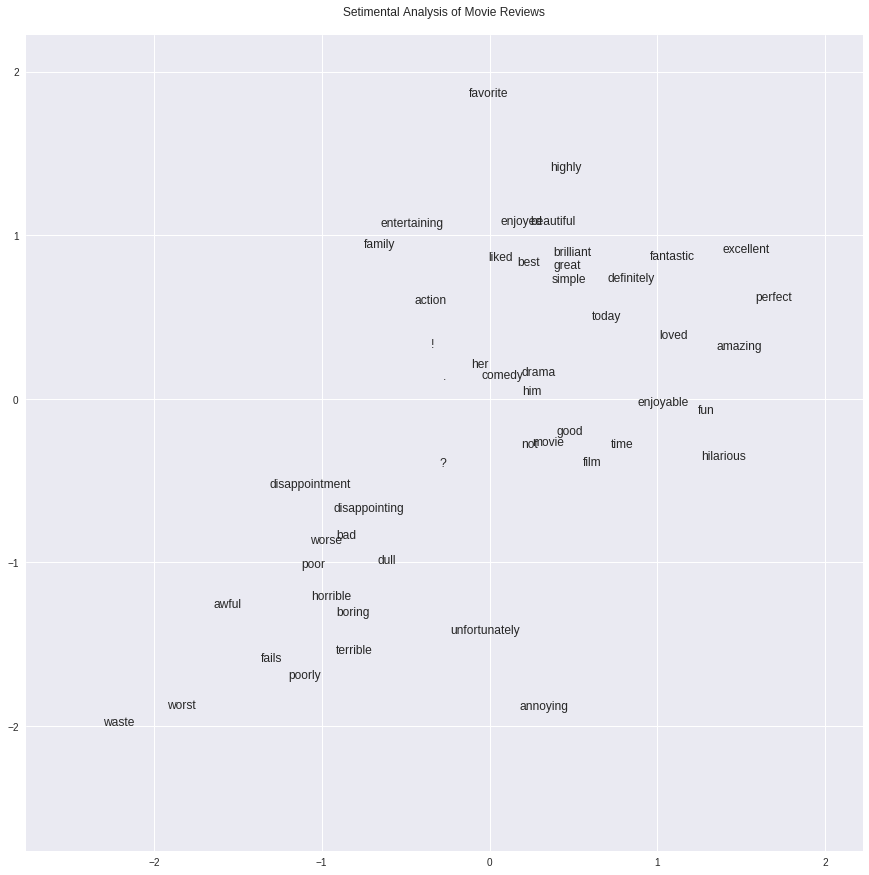

In [20]:
embedding_matrix = classifier.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    plt.text(embedding_xy[0], embedding_xy[1], informative_terms[term_index])

plt.rcParams["figure.figsize"] = (15, 15)
plt.title("Setimental Analysis of Movie Reviews\n")
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

### Revampment in the Model

In [15]:
!wget https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt -O /tmp/terms.txt

--2018-04-22 15:20:09--  https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253538 (248K) [text/plain]
Saving to: ‘/tmp/terms.txt’

/tmp/terms.txt      100%[===================>] 247.60K  --.-KB/s    in 0.004s  

2018-04-22 15:20:09 (62.9 MB/s) - ‘/tmp/terms.txt’ saved [253538/253538]



In [16]:
with open("/tmp/terms.txt", "r") as f:
    informative_terms1 = list(set(f.read().split()))

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
    key="terms", vocabulary_list=informative_terms1)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [10, 10],
    optimizer = my_optimizer
)

try:
    classifier.train(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )

    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([train_path]),
        steps = 1000
    )
    print("Training set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_fn([test_path]),
        steps = 1000
    )
    print("Testing set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)

Training set metrics: 
accuracy 0.8368
accuracy_baseline 0.5
auc 0.91206175
auc_precision_recall 0.9087822
average_loss 0.37869698
label/mean 0.5
loss 9.467424
prediction/mean 0.49767575
global_step 1000
---
Testing set metrics: 
accuracy 0.8198
accuracy_baseline 0.5
auc 0.8977975
auc_precision_recall 0.89425373
average_loss 0.40471867
label/mean 0.5
loss 10.117967
prediction/mean 0.49519107
global_step 1000
---
